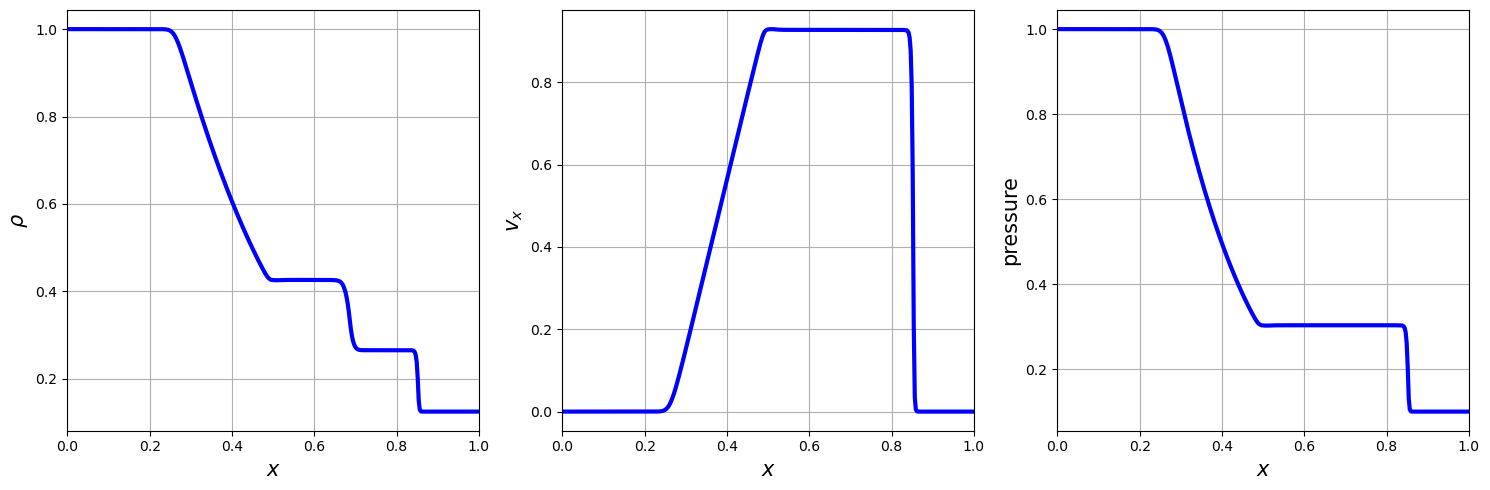

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

gamma = 1.4

@njit
def MC_RM(a, b, c):
    sign_a = np.sign(a)
    sign_b = np.sign(b)
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a + sign_b) * min(abs(a), abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i + sign_c) * min(abs(s_i), abs(c))
    return s_f

#numa 안정성
@njit
def U_conserved_1d(V):      # conserved parameter 1 D for difining constant value 
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    U = np.zeros(5)
    U[0] = rho
    U[1] = rho*vx
    U[2] = rho*vy
    U[3] = rho*vz
    U[4] = E
    return U

@njit
def U_conserved_2d(V):    # conserved parameter 2 D for putting to array
    N = V.shape[1]
    U = np.zeros((5, N))
    for i in range(N):
        rho = V[0, i]
        vx  = V[1, i]
        vy  = V[2, i]
        vz  = V[3, i]
        p   = V[4, i]
        E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)

        U[0, i] = rho
        U[1, i] = rho*vx
        U[2, i] = rho*vy
        U[3, i] = rho*vz
        U[4, i] = E
    return U

@njit
def V_primitive(U):  # Getting primitive variable from conserved variable
    N = U.shape[1]  # to make same form of matrix 
    V = np.zeros((5, N)) 
    for i in range(N):
        rho = U[0, i]
        vx  = U[1, i] / rho
        vy  = U[2, i] / rho
        vz  = U[3, i] / rho
        p   = (gamma-1.0) * (U[4, i] - 0.5*rho*(vx*vx + vy*vy + vz*vz))

        V[0, i] = rho
        V[1, i] = vx
        V[2, i] = vy
        V[3, i] = vz
        V[4, i] = p
    return V


@njit
def outgoing(V, nx, ng):
    V[:, :ng] = V[:, ng:ng+1]
    V[:, nx+ng:] = V[:, nx+ng-1:nx+ng]
    return V

@njit
def Flux(V):   #Flux
    rho = V[0]
    vx  = V[1]
    vy  = V[2]
    vz  = V[3]
    p   = V[4]

    F = np.zeros(5)
    F[0] = rho*vx
    F[1] = rho*vx*vx + p
    F[2] = rho*vx*vy
    F[3] = rho*vx*vz
    E = p/(gamma-1.0) + 0.5*rho*(vx*vx + vy*vy + vz*vz)
    F[4] = (E + p) * vx
    return F
    
@njit
def reconstruct_V(V, nx, ng):
    rows = V.shape[0]
    N = V.shape[1]
    V_L = np.zeros((5, N))
    V_R = np.zeros((5, N))
    dV  = np.zeros((5, N))

    for k in range(rows):
        for i in range(ng, nx+ng):
            a = V[k, i]   - V[k, i-1]
            b = 0.5 * (V[k, i+1] - V[k, i-1])
            c = V[k, i+1] - V[k, i]
            dV[k, i] = MC_RM(a, b, c)

    for k in range(5):
        for i in range(ng-1, nx+ng):   # interface i+1/2
            V_L[k, i] = V[k, i]   + 0.5*dV[k, i]
            V_R[k, i] = V[k, i+1] - 0.5*dV[k, i+1]

    return V_L, V_R

@njit
def HLL_Method(U, V, nx, ng, dx, dt):
    N = V.shape[1]
    V = outgoing(V, nx, ng)
    V_L, V_R = reconstruct_V(V, nx, ng)
    F = np.zeros((5, N))  
    for i in range(ng-1, nx+ng):
        VL = V_L[:, i]
        VR = V_R[:, i]
        
        rhoL, vxL, vyL, vzL, pL = VL
        rhoR, vxR, vyR, vzR, pR = VR

        UL = U_conserved_1d(VL)  # Make constant value for L 
        UR = U_conserved_1d(VR)  # Make constant value for R 

        csL = np.sqrt(gamma * pL / rhoL) # sound speed L
        csR = np.sqrt(gamma * pR / rhoR) # sound speed R

        EL = UL[4]
        ER = UR[4]

#  Roe average

        # H = (E + p) / rho 

        HL = (EL + pL) / rhoL  # Enthalpy L
        HR = (ER + pR) / rhoR  # Enthalpy R
 

        srL = np.sqrt(rhoL)
        srR = np.sqrt(rhoR)
        denom = srL + srR

        roe_V = (srL*vxL + srR*vxR) / denom  # Roe average of velocity
        roe_H = (srL*HL  + srR*HR ) / denom  # Roe average of Enthalpy
        roe_c = (gamma-1.0) * (roe_H - 0.5*roe_V*roe_V) # Roe sound speed average
        if roe_c < 0.0:
            roe_c = 0.0
        roe_cs = np.sqrt(roe_c)
# Roe average 는 좌/우 상태를 보존적으로 선형화한 상태
# => 안정한 경계 만듬 


# HLL + Rankine–Hugoniot jump conditions 
# SL : 실제 나올 수 있는 가장 왼쪽 파 속도의 하한
# SR : 실제 나올 수 있는 가장 오른쪽 파 속도의 상한
        SL = min(vxL - csL, vxR - csR, roe_V - roe_cs) # Euler characteristic velocity + Roe average characteristic
        SR = max(vxL + csL, vxR + csR, roe_V + roe_cs)

        FL = Flux(VL)
        FR = Flux(VR)


        if SL >= 0.0:
            F[:, i] = FL
        elif SR <= 0.0:
            F[:, i] = FR
        else:
            F[:, i] = (SR*FL - SL*FR + SL*SR*(UR - UL)) / (SR - SL)



    U_new = U.copy()

    for j in range(ng, nx+ng):
        U_new[:, j] = U[:, j] - dt/dx * (F[:, j] - F[:, j-1])

    return U_new

@njit
def RK2(U, V, nx, ng, dx, dt):
    U_1 = HLL_Method(U, V, nx, ng, dx, dt)
    V_1 = V_primitive(U_1)
    U_2 = HLL_Method(U_1, V_1, nx, ng, dx, dt)
    U = 0.5 * (U + U_2)
    return U


# ------------------- Run -------------------


x_min, x_max, nx = 0.0, 1.0, 400
dx = (x_max-x_min) / nx
x0 = 0.5
ng = 2
N = nx + 2*ng

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

lam = 0.5
Time = 0.0
Time_set = 0.2


# Sod shock tube problem

rho_L, vx_L, vy_L, vz_L, P_L = 1.0,   0.0, 0.0, 0.0, 1.0
rho_R, vx_R, vy_R, vz_R, P_R = 0.125, 0.0, 0.0, 0.0, 0.1

V = np.zeros((5, N))  # make discontinuities points based on x_0
for i in range(N):
    if x[i] < x0:
        V[:, i] = [rho_L, vx_L, vy_L, vz_L, P_L]  # Left region
    else:
        V[:, i] = [rho_R, vx_R, vy_R, vz_R, P_R]  # Right region




while Time < Time_set:
    V = outgoing(V, nx, ng)
    cs = np.sqrt(gamma * V[4, ng:nx+ng] / V[0, ng:nx+ng])  # sound speed for each cell
    umax = np.max(np.abs(V[1, ng:nx+ng]) + cs)
    dt = lam * dx / umax

    if Time + dt > Time_set:
        dt = Time_set - Time

    U =U_conserved_2d(V)
    # U = HLL_Method(U, V, nx, ng, dx, dt)
    U = RK2(U, V, nx, ng, dx, dt)
    V = V_primitive(U)

    Time += dt

# Plot
xp = x[ng:nx+ng]
rho = V[0, ng:nx+ng]
vx   = V[1, ng:nx+ng]
vy   = V[2, ng:nx+ng]
vz   = V[3, ng:nx+ng]
p   = V[4, ng:nx+ng]

fig = plt.figure(1,figsize=(15,5))

plt.subplot(131)
plt.plot(xp, rho,lw=3,color='b')
plt.xlabel(r"$x$",size=15)
plt.ylabel(r"$\rho$",size=15)

plt.xlim(0.0,1.0)

plt.grid(True)

plt.subplot(132)
plt.plot(xp, vx,lw=3,color='b')
plt.xlabel(r"$x$",size=15)
plt.ylabel(r"$v_x$",size=15)

plt.xlim(0.0,1.0)

plt.grid(True)


plt.subplot(133)
plt.plot(xp, p,lw=3,color='b')
plt.xlabel(r"$x$",size=15)
plt.ylabel("pressure",size=15)

plt.xlim(0.0,1.0)

plt.grid(True)

plt.tight_layout()